In [ ]:
!pip install geopandas shapely seaborn matplotlib tqdm folium --quiet

import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import folium
from folium.plugins import HeatMap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_path = '/content/drive/MyDrive/traffic_project/'
us_file = project_path + 'US_Accidents_Cleaned_Sample.csv'
osm_chunk1_file = project_path + 'OSM_Roads_Chunk1.gpkg'

print("📂 Loading datasets...")
us_df = pd.read_csv(us_file)
osm_gdf = gpd.read_file(osm_chunk1_file)

print("✅ US accidents:", us_df.shape)
print("✅ OSM chunk 1:", osm_gdf.shape)

📂 Loading datasets...
✅ US accidents: (400000, 15)
✅ OSM chunk 1: (969390, 7)


In [ ]:
sample_size = 80000
if len(us_df) > sample_size:
    us_df = us_df.sample(sample_size, random_state=42)
print(f"📉 Sampled {len(us_df)} accident records")

📉 Sampled 80000 accident records


In [ ]:
us_gdf = gpd.GeoDataFrame(
    us_df,
    geometry=gpd.points_from_xy(us_df['Start_Lng'], us_df['Start_Lat']),
    crs="EPSG:4326"
)
us_gdf = us_gdf.to_crs(epsg=3857)
osm_gdf = osm_gdf.to_crs(epsg=3857)

print("✅ CRS aligned to EPSG:3857")

✅ CRS aligned to EPSG:3857


In [ ]:
print("🔄 Integrating datasets — finding nearest road for each accident...")
merged = gpd.sjoin_nearest(us_gdf, osm_gdf, how='left', distance_col='distance_to_road')
print("✅ Spatial join complete:", len(merged), "rows")

🔄 Integrating datasets — finding nearest road for each accident...
✅ Spatial join complete: 80151 rows


In [ ]:
final_cols = [
    'ID','Severity','Start_Time','City','State',
    'Temperature(F)','Humidity(%)','Visibility(mi)',
    'Wind_Speed(mph)','Precipitation(in)','Weather_Condition','Sunrise_Sunset',
    'highway','lanes','maxspeed','length','distance_to_road'
]

integrated_dataset = merged[final_cols].copy()


output_file = project_path + 'integrated_dataset.csv'
integrated_dataset.to_csv(output_file, index=False)
print(f"💾 Saved final integrated dataset")

💾 Saved final integrated dataset


In [ ]:
print("\n--- Missing Values ---")
print(integrated_dataset.isna().sum())

print("\n--- Descriptive Stats ---")
print(integrated_dataset.describe())



--- Missing Values ---
ID                       0
Severity                 0
Start_Time               0
City                     0
State                    0
Temperature(F)        1222
Humidity(%)           1257
Visibility(mi)        1714
Wind_Speed(mph)      14938
Precipitation(in)        0
Weather_Condition        0
Sunrise_Sunset           0
highway                  0
lanes                    0
maxspeed                 0
length                   0
distance_to_road         0
dtype: int64

--- Descriptive Stats ---
           Severity  Temperature(F)   Humidity(%)  Visibility(mi)  \
count  80151.000000    78929.000000  78894.000000    78437.000000   
mean       2.366483       63.014578     65.055682        9.189323   
std        0.484635       17.426826     21.397379        2.143108   
min        1.000000       -0.000000      4.000000        0.000000   
25%        2.000000       52.200000     50.000000       10.000000   
50%        2.000000       64.800000     66.000000       10.0000

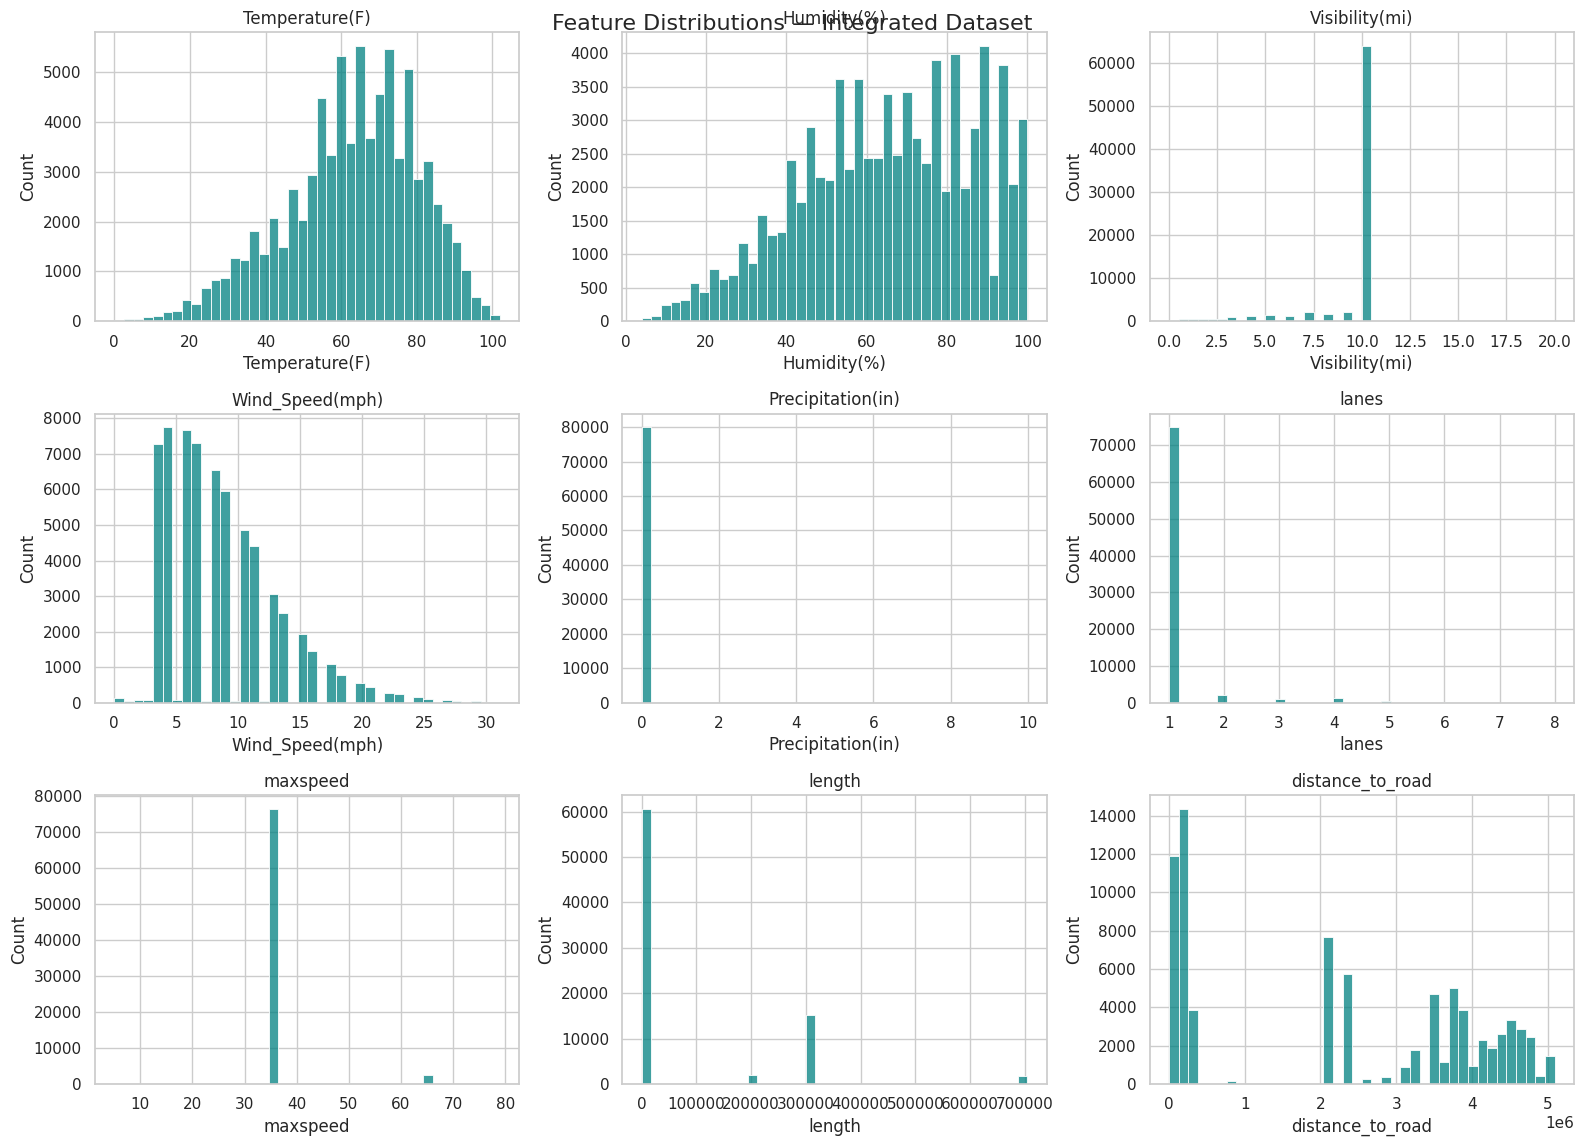

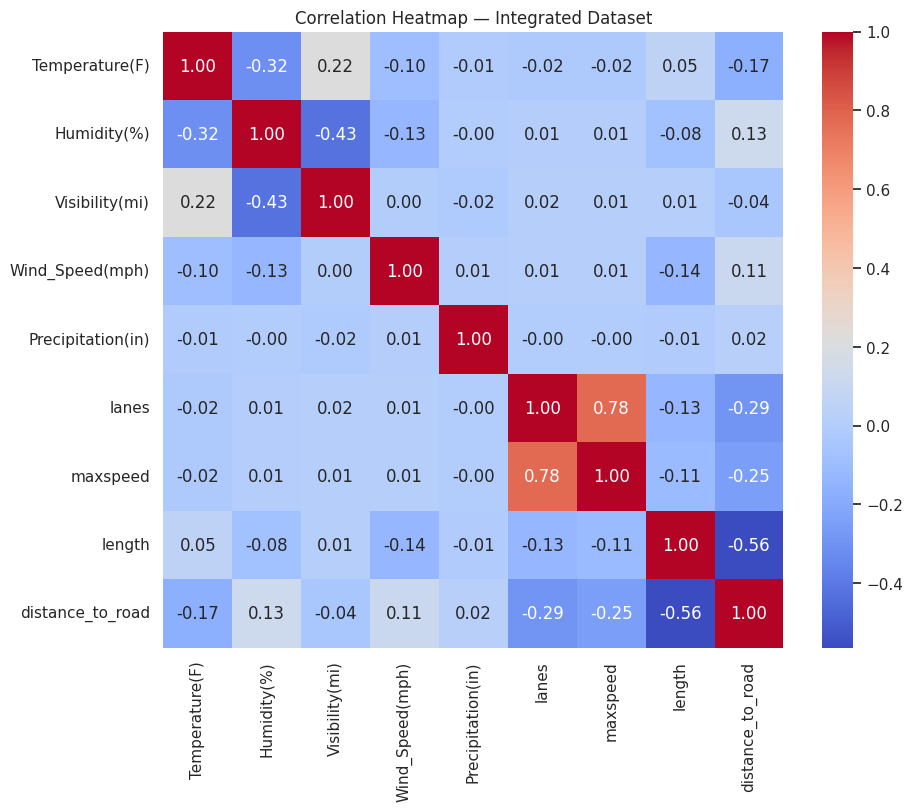

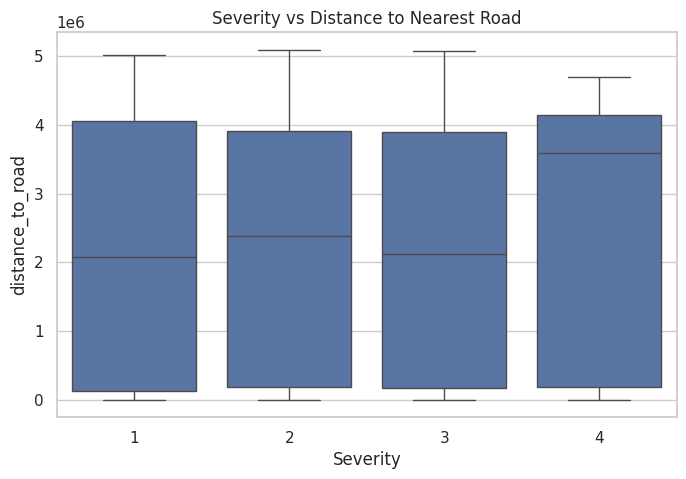

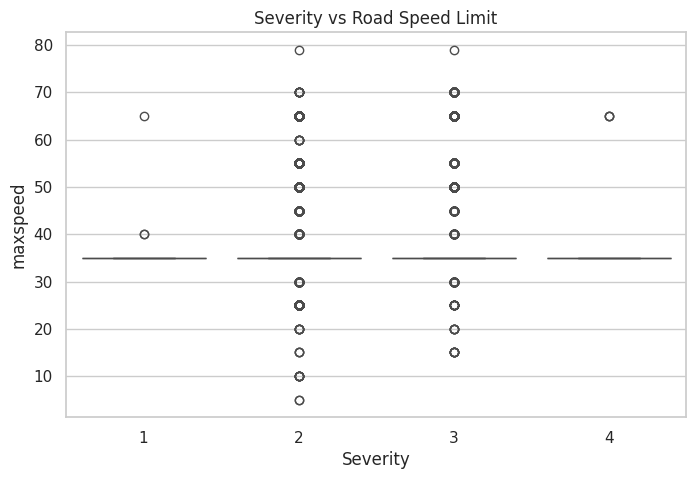

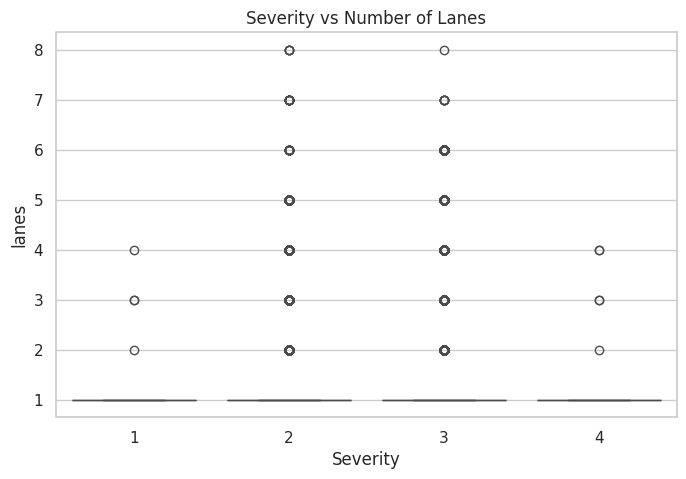

🌍 Interactive heatmap saved as 'Integrated_Heatmap.html' in Drive


In [ ]:
sns.set(style="whitegrid")
num_features = [
    'Temperature(F)','Humidity(%)','Visibility(mi)','Wind_Speed(mph)',
    'Precipitation(in)','lanes','maxspeed','length','distance_to_road'
]

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
fig.suptitle("Feature Distributions — Integrated Dataset", fontsize=16, y=0.95)
for ax, col in zip(axes.flatten(), num_features):
    sns.histplot(integrated_dataset[col], bins=40, ax=ax, color="teal")
    ax.set_title(col)
plt.tight_layout()
plt.show()
corr = integrated_dataset[num_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap — Integrated Dataset")
plt.show()
plt.figure(figsize=(8,5))
sns.boxplot(x='Severity', y='distance_to_road', data=integrated_dataset)
plt.title("Severity vs Distance to Nearest Road")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='Severity', y='maxspeed', data=integrated_dataset)
plt.title("Severity vs Road Speed Limit")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='Severity', y='lanes', data=integrated_dataset)
plt.title("Severity vs Number of Lanes")
plt.show()
us_latlon = us_gdf.to_crs(epsg=4326)
acc_sample = us_latlon.sample(min(5000, len(us_latlon)))

center = [acc_sample['geometry'].y.mean(), acc_sample['geometry'].x.mean()]
m = folium.Map(location=center, zoom_start=6)
HeatMap(data=[[p.y, p.x] for p in acc_sample.geometry]).add_to(m)

m.save(project_path + "Integrated_Heatmap.html")
print("🌍 Interactive heatmap saved as 'Integrated_Heatmap.html' in Drive")
m
